# Buffering data

In some analysis it is necessary to find the influence of a feature in the surrounding areas, in this situation the `buffer` operation will help.

To create buffers, first add the `geopandas` package.

In [1]:
from pathlib import Path
import geopandas as gp
base_path = Path.cwd().parents[0]
INPUT = base_path / "00_data"
OUTPUT = base_path / "out"

The input data is then loaded:

In [ ]:
input_layer = gp.read_file(OUTPUT / "clipped.shp")[:5]

Since the input layer will be modified by the buffer operation, a copy of the input layer will be created.

In [4]:
buffer_layer = input_layer.copy()

Using the `buffer` method, buffers are created by modifying the geometry of the input layer. The value defined within the buffer method is the size of the buffer and its unit depends on the coordinate system of the layer.

```{admonition} **Example of Units**
:class: note, dropdown
- WGS 84 (EPSG Code:4326): **Degrees**.
- ETRS89 / UTM Zone 32N (EPSG Code:25832): **Meters**.
```

In [5]:
buffer_layer['geometry'] = input_layer['geometry'].buffer(20)

The result is visualized using the parameters in the `plot` function: 
- `ax`: This parameter in the plot function, which refers to the Axes object, overlays multiple plots on a map.
- `alpha`: This parameter (ranges from 0 (fully transparent) to 1) controls the transparency of the layers for better visualization.

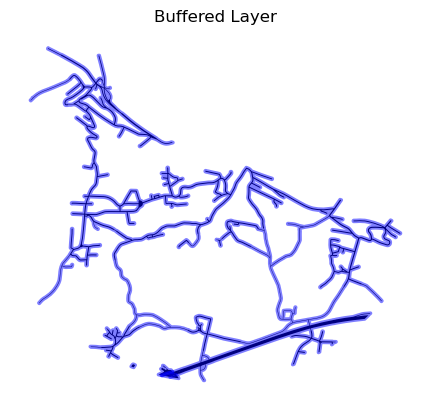

In [7]:
ax = input_layer.plot(color='black', alpha=1)

buffer_layer.plot(ax=ax, color='blue', alpha=0.5)
ax.set_title("Buffered Layer")
ax.set_axis_off()

When the layers are printed, the number of rows (features) is the same before and after the buffer operation. This shows that the overlapping features are not merged:

The `dissolve` function is used to merge all the buffers at once:

In [9]:
dissolved_buffer = buffer_layer.dissolve()
dissolved_buffer

,geometry,KS_IS,CLC_st1,CLC18,CLC,Biotpkt201,Shape_Leng,Shape_Area
0,"MULTIPOLYGON (((402975.429 5657984.424, 402953...",SV,122,231,231.0,5.271487,487783.286284,2.869516e+06


In cases where only the merging of overlapping buffers is required, the overlapping areas need to be identified first.

In [11]:
overlapping_buffers = gp.sjoin(
    buffer_layer[['geometry']], 
    buffer_layer[['CLC18','geometry']], 
    how="inner", 
    predicate="intersects")
overlapping_buffers.head(3)

,geometry,index_right,CLC18
0,"POLYGON ((401554.378 5661025.919, 401554.618 5...",1,231
0,"POLYGON ((401554.378 5661025.919, 401554.618 5...",3,122
0,"POLYGON ((401554.378 5661025.919, 401554.618 5...",2,231


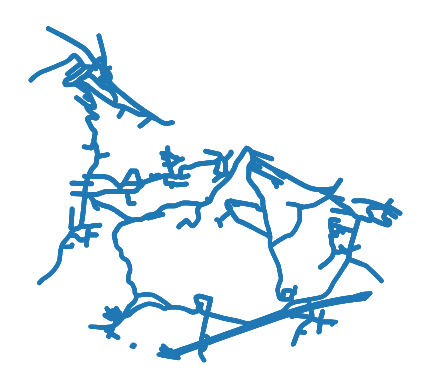

In [14]:
ax = overlapping_buffers.plot()
ax.set_axis_off()

Then the dissolve operation is performed to merge only the overlapping buffers.

In [15]:
dissolving_buffer = overlapping_buffers.dissolve()
dissolving_buffer

,geometry,index_right,CLC18
0,"MULTIPOLYGON (((402975.429 5657984.424, 402953...",1,231


```{admonition} **Buffer Parameters**
:class: tip, dropdown
In addition to the `distance` parameter, which indicates the size of the buffer, there are other parameters that help in processing and visualizing the output. 

`resolution` is a parameter that defines the number of segments used to create a quarter circle. The larger values for this parameter cause slower processing.

`cap_style`defines the shape of the end of the buffer, which is mostly used for line features. 
- cap_style = **1** defines **Round** shape.
- cap_style = **2** defines **Flat** shape.
- cap_style = **3** defines **Square** shape.

`join_style` defines the shape of the corner and edges in the buffers.
- join_style = **1** defines **Round** shape.
- join_style = **2** defines **Mitre** shape.
- join_style = **3** defines **Bevel** shape.
```

```{figure} https://geopandas.org/en/stable/_images/buffer.png
:height: 500px
:name: figure-example

Visualization of Buffer Parameters (Source: [GeoPandas website](https://geopandas.org/en/stable/_images/buffer.png)).
```

The following code creates a buffer of 20 units with a resolution of 8, rounded ends, and beveled corners.

In [16]:
buffer_layer['geometry'] = input_layer['geometry'].buffer(
    distance=20, 
    resolution=8, 
    cap_style=2, 
    join_style=3)

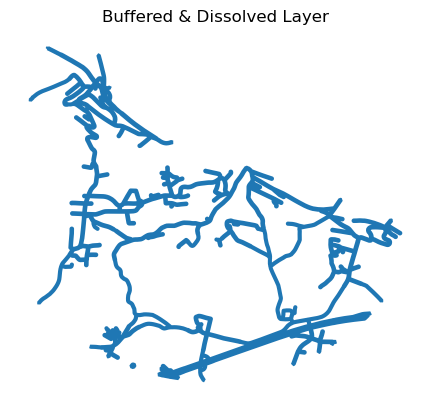

In [17]:
ax = buffer_layer.plot()
ax.set_title("Buffered & Dissolved Layer")
ax.set_axis_off()

## Negative buffer

Sometimes a feature is so large that it affects the analysis. In such cases, a negative buffer is defined to reduce the impact of the feature itself.

In this case, simply define a negative value for the `distance` parameter, instead of a positive value.

In [ ]:
buffer_layer['geometry'] = input_layer['geometry'].buffer(distance=-0.5) 

In [ ]:
ax = buffer_layer.plot()
ax.set_title("Negative Buffer Layer")
ax.set_axis_off()

## Multi-Ring Buffers

To analyze the effect of a feature at different distances, it can be helpful to create concentric buffer zones (multi-ring buffers) around the feature.

To achieve this, the buffer distances of interest are defined as a list.

In [ ]:
distances = [-0.2,5,10] 

A for loop is used to create buffers around each feature and then merge them into a single GeoDataFrame.

In [ ]:
buffers = pd.concat(
    [input_layer.geometry.buffer(distance) for distance in distances],
    ignore_index=True
)

In [ ]:
ax = buffers.plot()
ax.set_title("Multi-Ring Buffers Layer")
ax.set_axis_off()